In [1]:
import sys
import os
import random
import gc
import time
import torch
import numpy as np
import pandas as pd
import ast
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr, kendalltau, rankdata
from sklearn.metrics import ndcg_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG.rag_shap import *
from SHapRAG.utils import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df= pd.read_csv("../data/synthetic_data/20_synergy_hard_negatives.csv",index_col=False, sep=";")
# df= pd.read_csv("../data/complementary.csv")

In [ ]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
# model_path = "mistralai/Mistral-7B-Instruct-v0.3"
model_path = "meta-llama/Llama-3.1-8B-Instruct"
# model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()

In [ ]:
num_questions_to_run=len(df.question)
# num_questions_to_run=1
k_values = [1,2,3,4,5]
all_results=[]
extras=[]
# Define ground truth set of docs for precision (adapt as needed)
# e.g., if first 2 docs are always relevant
def get_gtset_k():
    return [0, 1]
correctness=[]
llm_response=[]
for i in tqdm(range(num_questions_to_run), disable=not accelerator_main.is_main_process):
    query = df.question[i]
    if accelerator_main.is_main_process:
        print(f"\n--- Question {i+1}/{num_questions_to_run}: {query[:60]}... ---")

    p = ast.literal_eval(df.context[i])
    docs = p[:5] + [p[1]] + p[5:]
    utility_cache_base_dir = f"../Experiment_data/synthetic/{model_path.split('/')[1]}/duplicates"
    utility_cache_filename = f"utilities_q_idx{i}.pkl"
    current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)

    if accelerator_main.is_main_process:
        os.makedirs(os.path.dirname(current_utility_path), exist_ok=True)

    harness = ContextAttribution(
        items=docs,
        query=query,
        prepared_model=prepared_model,
        prepared_tokenizer=tokenizer,
        accelerator=accelerator_main,
        utility_cache_path=current_utility_path
    )
    # res = evaluate(df.question[i], harness.target_response, df.answer[i])
    # correctness.append(res)
    # llm_response.append(harness.target_response)
    # if res=="True":

    if accelerator_main.is_main_process:
        methods_results = {}
        metrics_results = {}
        extra_results = {}

        m_samples_map = {"L": 264}

        # Store FM models for later R²/MSE
        fm_models = {}

        for size_key, num_s in m_samples_map.items():
            if 2 ** len(docs) < num_s and size_key != "L":
                actual_samples = max(1, 2 ** len(docs) - 1 if 2 ** len(docs) > 0 else 1)
            else:
                actual_samples = num_s

            if actual_samples > 0:
                methods_results[f"ContextCite{actual_samples}"], model_cc = harness.compute_contextcite(
                    num_samples=actual_samples, seed=SEED
                )

                attributions, interactions= harness.compute_spex(sample_budget=actual_samples, max_order=2)
                methods_results[f"FBII{actual_samples}"] = attributions['fbii']
                methods_results[f"Spex{actual_samples}"] = attributions['fourier']
                methods_results[f"FSII{actual_samples}"] = attributions['fsii']

                # methods_results[f"FM_WeightsDU{actual_samples}"], Fdu, modelfmdu = harness.compute_wss(
                #     num_samples=actual_samples, seed=SEED, sampling="uniform",
                #     sur_type="fm", utility_mode="divergence_utility"
                # )
                # methods_results[f"FM_WeightsDK{actual_samples}"], Fdk, modelfmdk = harness.compute_wss(
                #     num_samples=actual_samples, seed=SEED, sampling="kernelshap",
                #     sur_type="fm", utility_mode="divergence_utility"
                # )
                # methods_results[f"FM_WeightsLK{actual_samples}"], Flk, modelfmlk = harness.compute_wss(
                #     num_samples=actual_samples, seed=SEED, sampling="kernelshap", sur_type="fm"
                # )
                methods_results[f"FM_WeightsLU{actual_samples}"], Flu, modelfmlu = harness.compute_wss(
                    num_samples=actual_samples, seed=SEED, sampling="uniform", sur_type="fm"
                )

                # Save FM models
                fm_models.update({
                    # f"FM_WeightsDU{actual_samples}": modelfmdu,
                    # f"FM_WeightsDK{actual_samples}": modelfmdk,
                    # f"FM_WeightsLK{actual_samples}": modelfmlk,
                    f"FM_WeightsLU{actual_samples}": modelfmlu
                })

                # Save extra Fs
                extra_results.update({
                    # "Fdu": Fdu,
                    # "Fdk": Fdk,
                    # "Flk": Flk,
                    "Flu": Flu,
                    "Int_FSII":interactions['fsii'],
                    "Int_FBII":interactions['fbii'],
                    "Int_Spex":interactions['fourier']
                })

        methods_results["LOO"] = harness.compute_loo()
        methods_results["ARC-JSD"] = harness.compute_arc_jsd()

        # --- Evaluation Metrics ---
        metrics_results["topk_probability"] = harness.evaluate_topk_performance(
            methods_results, k_values, utility_type="probability", modeld=None, modelu=modelfmlu
        )
        # metrics_results["topk_divergence"] = harness.evaluate_topk_performance(
        #     methods_results, k_values, utility_type="divergence", modelk=None, modelu=modelfmlu
        # )
        # metrics_results["topk_response_probability"] = harness.top_k_response_probability(
        #     methods_results, k_values=[1, 2,3]
        # )

        # R² and MSE for ContextCite
        r2, mse = harness.r2_mse(30, 'logit-prob', model_cc, method='cc')
        metrics_results["R2_cc"] = r2
        metrics_results["MSE_cc"] = mse

        # R² and MSE for each FM method that has a model
        for method_name, fm_model in fm_models.items():
            r2, mse = harness.r2_mse(30, 'logit-prob', fm_model, method='fm')
            metrics_results[f"R2_{method_name}"] = r2
            metrics_results[f"MSE_{method_name}"] = mse

        # LDS per method
        LDS = {}
        for method_name, scores in methods_results.items():
            if "FM_WeightsLU" in method_name:
                LDS[method_name] = harness.lds(scores, 30, utl=True, model=modelfmlu)
            # if "FM_WeightsLK" in method_name:
            #     LDS[method_name] = harness.lds(scores, 30, utl=True, model=modelfmlk)
            else:
                LDS[method_name] = harness.lds(scores, 30)
        metrics_results["LDS"] = LDS

        # Precision per method
        # precision_scores = {}
        # gtset_k = get_gtset_k()
        # for method_name, scores in methods_results.items():
        #     precision_scores[method_name] = harness.precision(gtset_k, scores)
        # metrics_results["precision"] = precision_scores

        harness.save_utility_cache(current_utility_path)

        all_results.append({
            "query_index": i,
            "query": query,
            "ground_truth": df.answer[i],
            "response": harness.target_response,
            "methods": methods_results,
            "metrics": metrics_results
        })
        extras.append(extra_results)
# df['correctness']=correctness
# df['llm_response']=llm_response

In [3]:
with open(f"../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/results.pkl", "rb") as f:
    all_results = pickle.load(f)

with open(f"../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/extras.pkl", "rb") as f:
    extras = pickle.load(f)

In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict

def summarize_and_print(all_results, k_values=[1, 2, 3,4,5]):
    table_data = defaultdict(lambda: defaultdict(list))

    # Mapping for consistency
    method_name_map = {
        
    }

    for res in all_results:
        metrics = res["metrics"]


        # LDS and R2
        for method_name, lds_val in metrics["LDS"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["LDS"].append(lds_val)

        for method_name, lds_val in metrics["R2"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["R2"].append(lds_val)
        # Top-k
        for method_name, k_dict in metrics["topk_probability"].items():
            method = method_name_map.get(method_name, method_name)
            for k in k_values:
                if k in k_dict:
                    col_name = f"topk_probability_k{k}"
                    table_data[method][col_name].append(k_dict[k])

    # Averages
    avg_table = {
        method: {metric: np.nanmean(values) for metric, values in metric_dict.items()}
        for method, metric_dict in table_data.items()
    }

    # Standard deviations for LDS, R², and MSE
    for method, metric_dict in table_data.items():
        for metric in ["LDS", "R2"]:
            if metric in metric_dict:
                avg_table[method][f"{metric}_std"] = np.nanstd(metric_dict[metric])

    df_summary = pd.DataFrame.from_dict(avg_table, orient="index").sort_index()

    print("\n=== Metrics Summary Across All Queries ===")
    print(df_summary.to_string(float_format="%.4f"))

    return df_summary


In [5]:
df_res=summarize_and_print(all_results, k_values=[1, 2, 3,4,5])


=== Metrics Summary Across All Queries ===
                      LDS      R2  topk_probability_k1  topk_probability_k2  topk_probability_k3  topk_probability_k4  topk_probability_k5  LDS_std  R2_std
ARC-JSD            0.6078 -0.8479               5.3498               8.5350               9.3285              10.6990              12.2404   0.1583  0.6187
ContextCite_128    0.5540  0.4222               1.8843              12.9210              13.7339              14.8317              15.1945   0.1606  0.1009
ContextCite_264    0.5774  0.4751               1.8601              12.8331              13.7493              14.7560              14.6779   0.1657  0.1020
ContextCite_32     0.5714  0.4172               3.1393              11.5755              13.9524              14.6378              14.0600   0.1811  0.1656
ContextCite_528    0.6036  0.5245               1.8760              12.8331              13.9524              14.7787              14.9350   0.1732  0.0970
ContextCite_64     0

/tmp/ipykernel_2831568/2845139303.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_budgeted['family'] = df_budgeted['method'].apply(lambda x: "_".join(x.split("_")[:-1]))
/tmp/ipykernel_2831568/2845139303.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_budgeted['budget'] = df_budgeted['method'].apply(lambda x: int(x.split("_")[-1]))


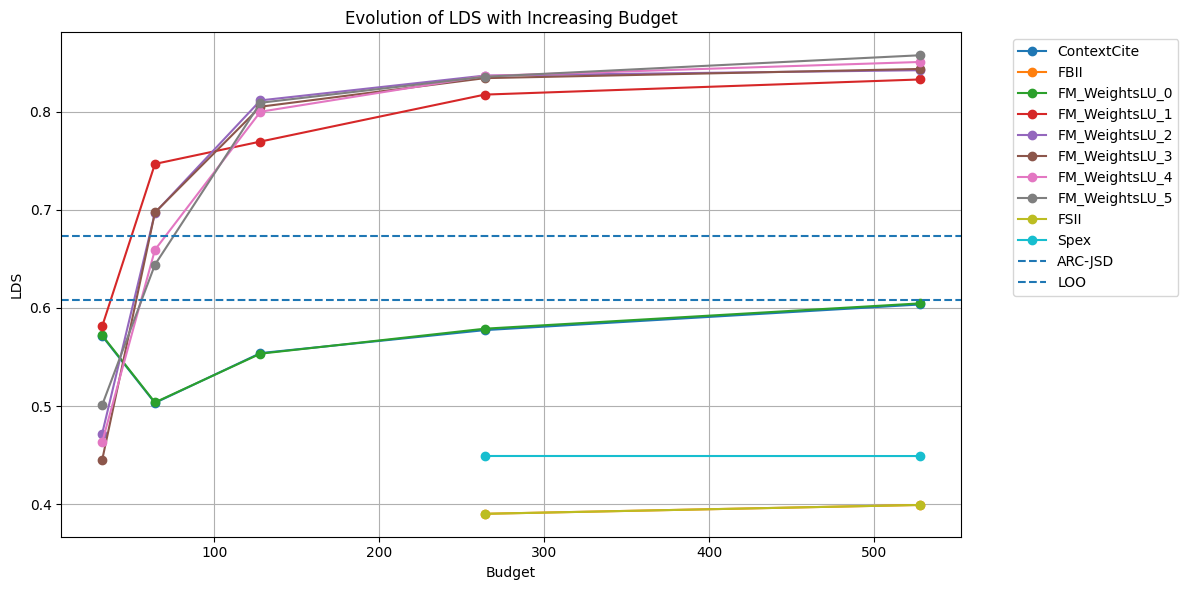

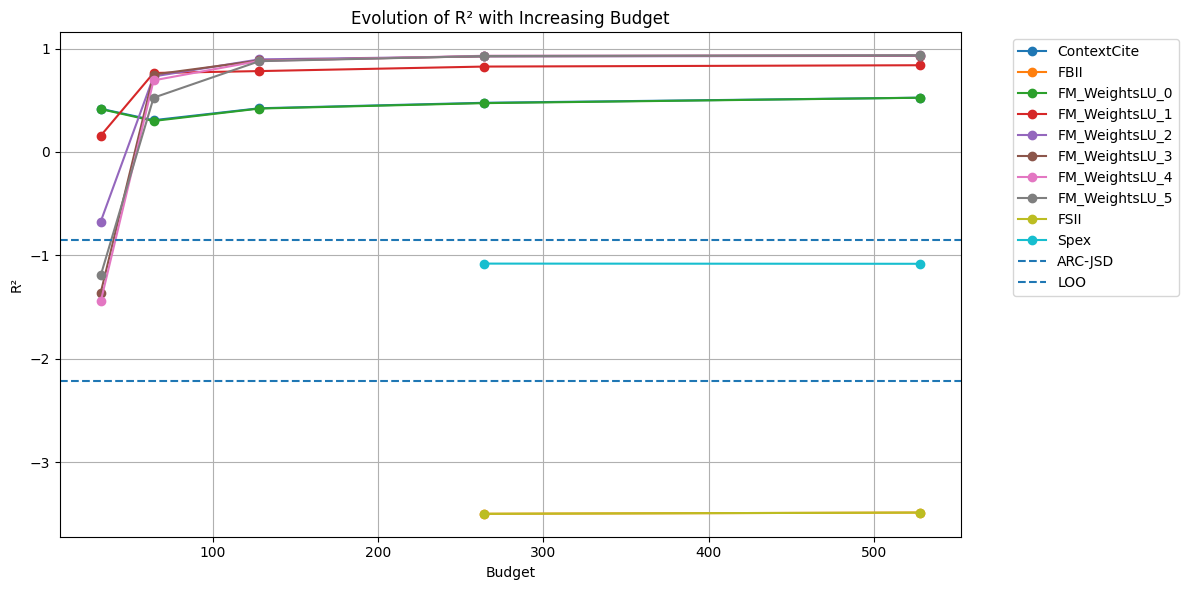

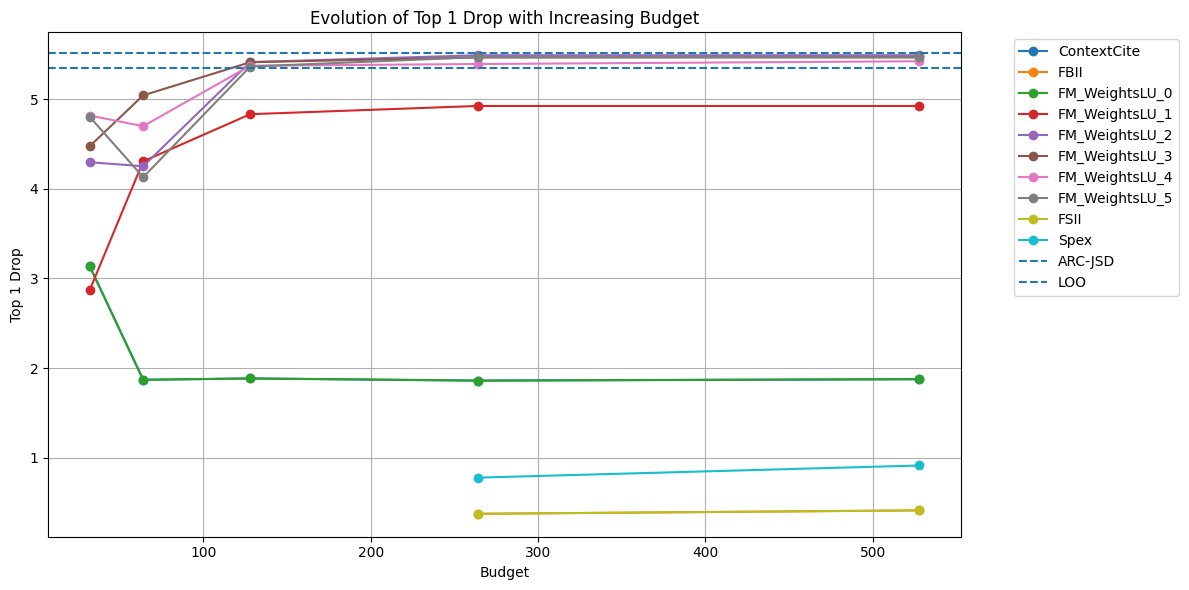

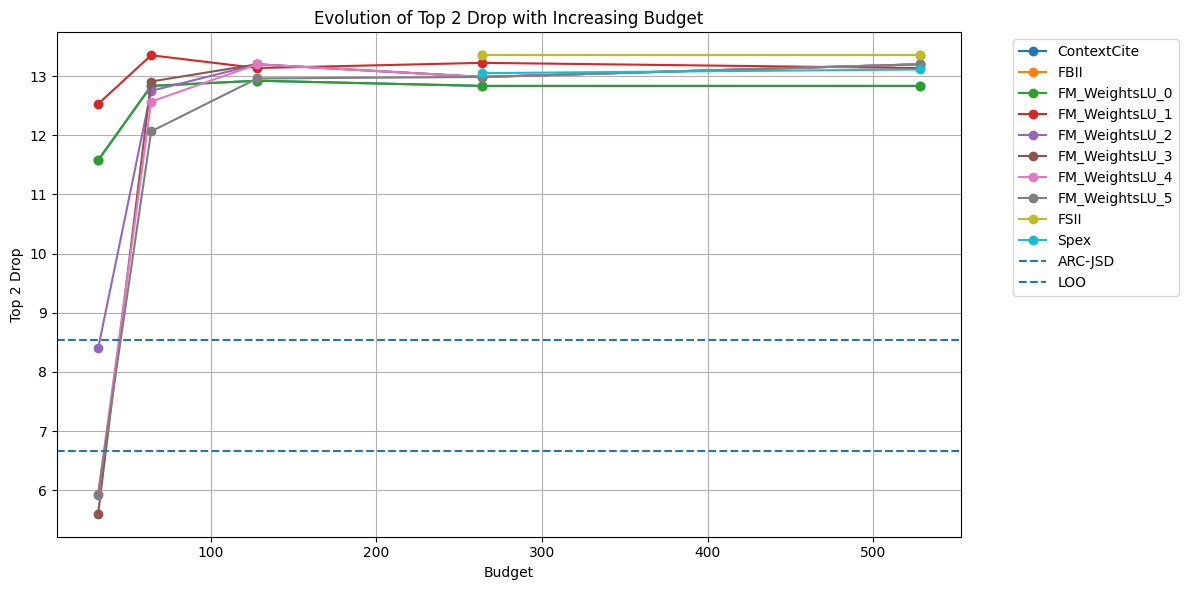

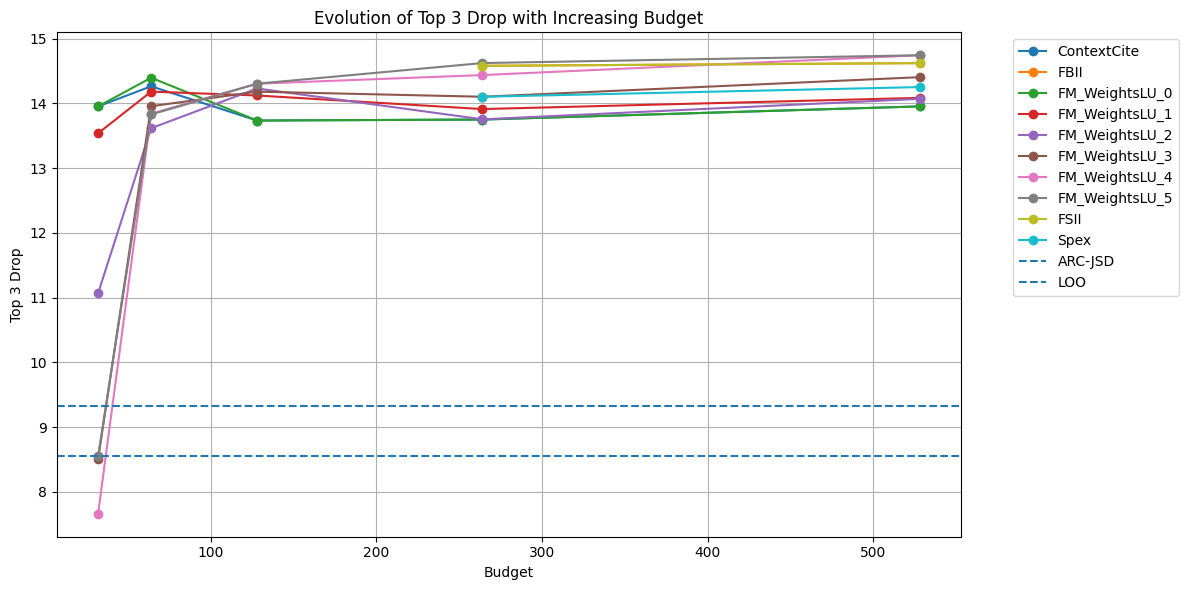

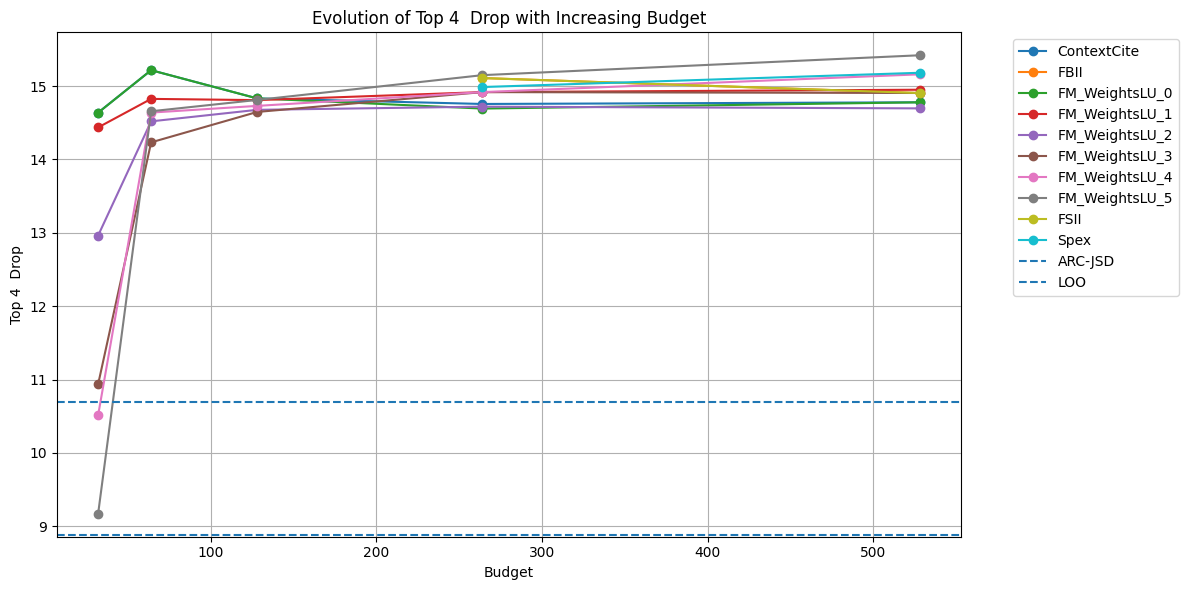

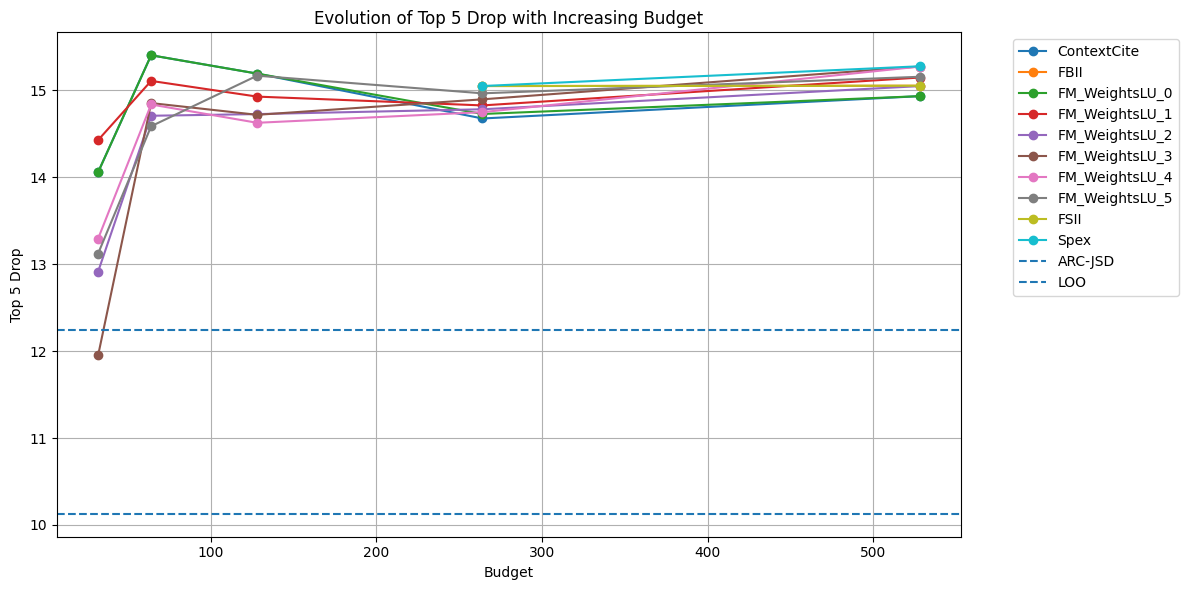

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Separate constant methods (no budget) and budgeted methods
constant_methods = ['LOO', 'ARC-JSD']
df_const = df_reset[df_reset['method'].isin(constant_methods)]
df_budgeted = df_reset[~df_reset['method'].isin(constant_methods)]

# Extract family and budget for budgeted methods
df_budgeted['family'] = df_budgeted['method'].apply(lambda x: "_".join(x.split("_")[:-1]))
df_budgeted['budget'] = df_budgeted['method'].apply(lambda x: int(x.split("_")[-1]))
df_budgeted = df_budgeted.sort_values(by=['family', 'budget'])

# Function to plot metric
def plot_metric(metric, ylabel):
    plt.figure(figsize=(12, 6))

    # Plot budgeted families
    families = df_budgeted['family'].unique()
    for fam in families:
        subset = df_budgeted[df_budgeted['family'] == fam]
        plt.plot(subset['budget'], subset[metric], marker='o', label=fam)

    # Plot constant methods as horizontal lines
    for _, row in df_const.iterrows():
        plt.axhline(y=row[metric], linestyle='--', label=row['method'])

    plt.xlabel("Budget")
    plt.ylabel(ylabel)
    plt.title(f"Evolution of {ylabel} with Increasing Budget")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot LDS
plot_metric("LDS", "LDS")

# Plot R²
plot_metric("R2", "R²")

plot_metric("topk_probability_k1", "Top 1 Drop")
plot_metric("topk_probability_k2", "Top 2 Drop")
plot_metric("topk_probability_k3", "Top 3 Drop")
plot_metric("topk_probability_k4", "Top 4  Drop")
plot_metric("topk_probability_k5", "Top 5 Drop")


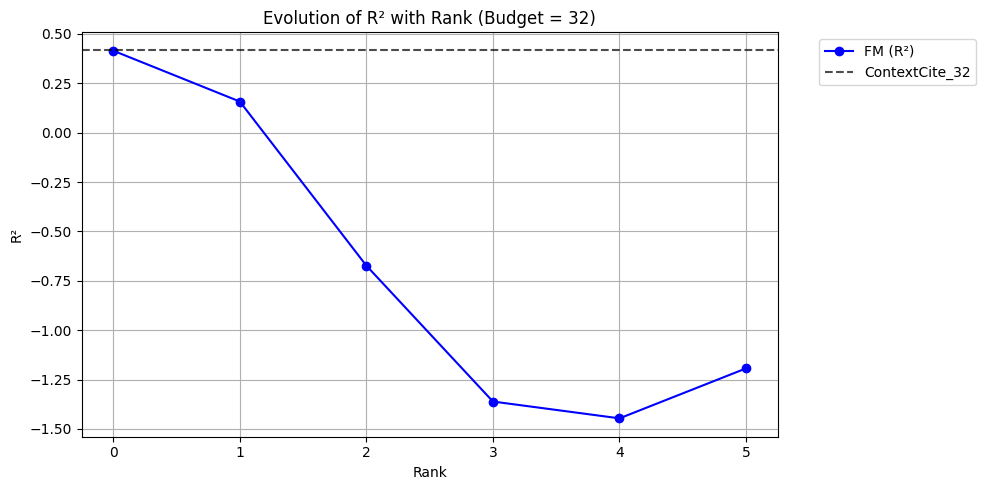

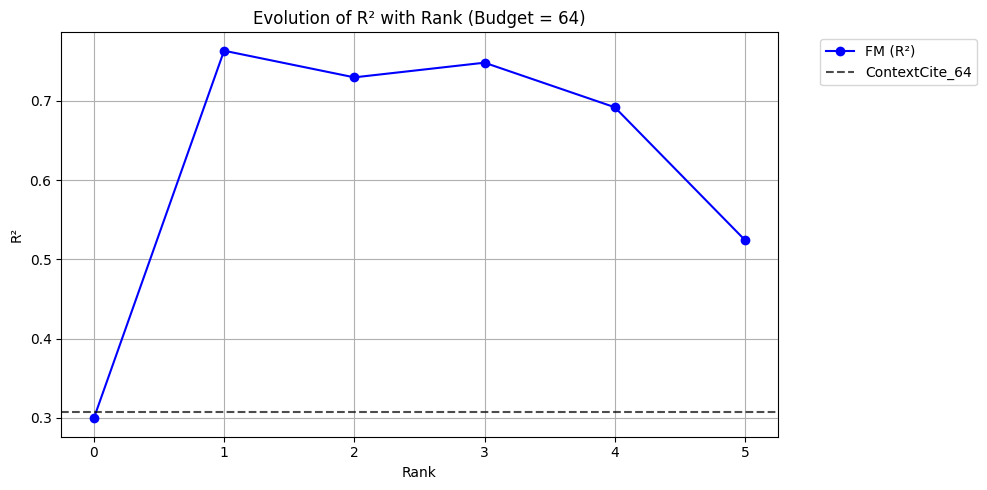

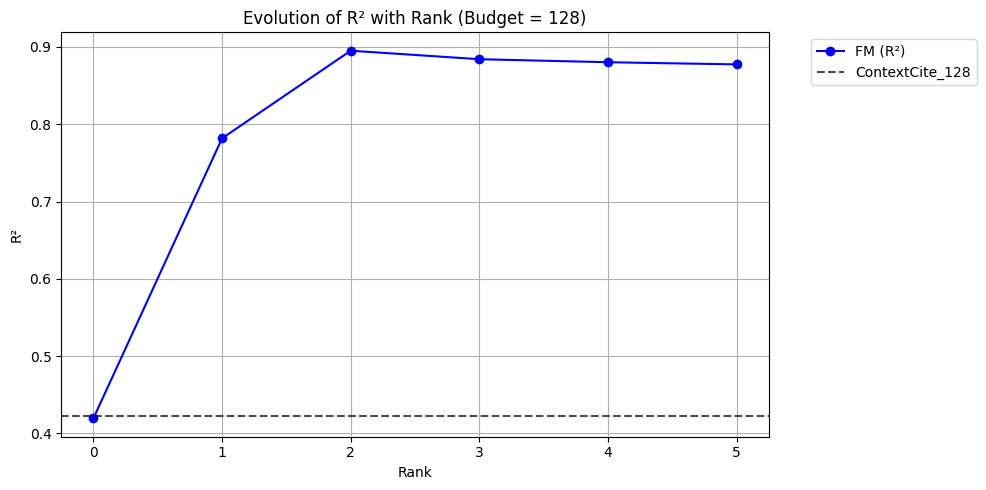

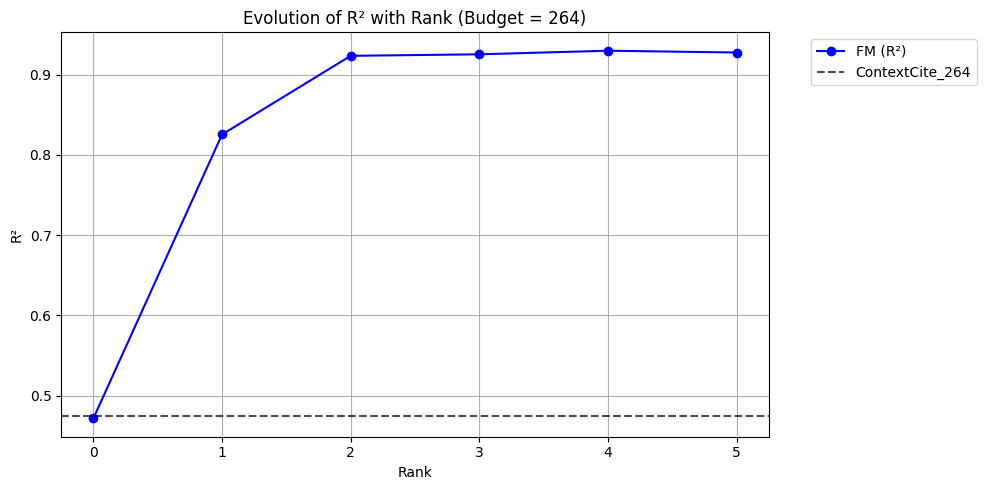

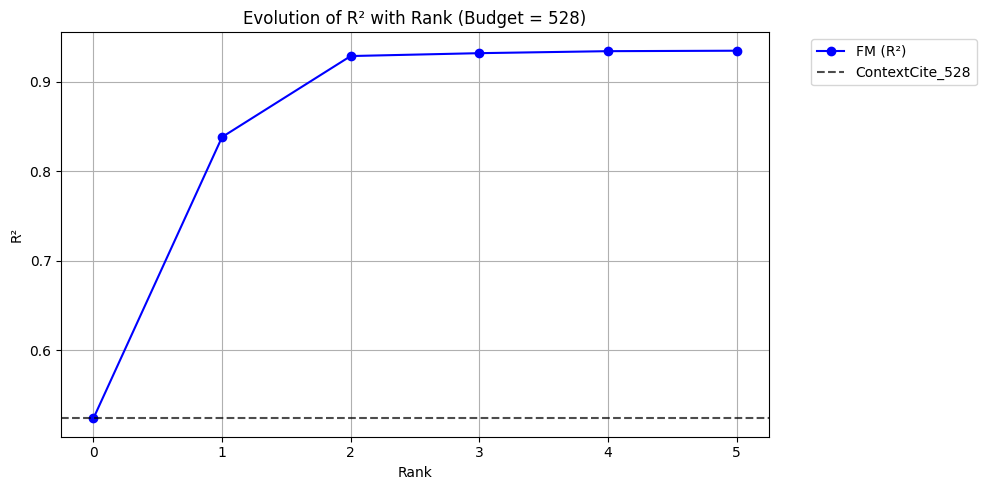

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Parse FM methods (rank + budget)
def parse_fm(method):
    parts = method.split("_")
    if parts[0] == "FM" and "WeightsLU" in parts[1]:
        rank = int(parts[2])
        budget = int(parts[-1])
        return rank, budget
    return None, None

df_reset['rank'], df_reset['budget'] = zip(*df_reset['method'].apply(parse_fm))

# Separate FM and non-FM methods
df_fm = df_reset[df_reset['rank'].notnull()]
df_nonfm = df_reset[df_reset['rank'].isnull()]

# Keep only ContextCite baselines
df_contextcite = df_nonfm[df_nonfm['method'].str.startswith("ContextCite")]

# Function to plot R² for a given budget
def plot_r2_for_budget(budget):
    plt.figure(figsize=(10, 5))

    # Subset FM methods for this budget
    subset_fm = df_fm[df_fm['budget'] == budget].sort_values(by='rank')

    # Plot FM evolution (R² vs rank)
    plt.plot(subset_fm['rank'], subset_fm['R2'], marker='o', color="blue", label="FM (R²)")

    # Plot only ContextCite baselines for this budget
    for _, row in df_contextcite.iterrows():
        if row['method'].endswith(f"_{budget}"):
            plt.axhline(y=row['R2'], linestyle='--', color="black", alpha=0.7, label=row['method'])

    plt.xlabel("Rank")
    plt.ylabel("R²")
    plt.title(f"Evolution of R² with Rank (Budget = {budget})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot for budget = 528
plot_r2_for_budget(32)
plot_r2_for_budget(64)
plot_r2_for_budget(128)
plot_r2_for_budget(264)
plot_r2_for_budget(528)

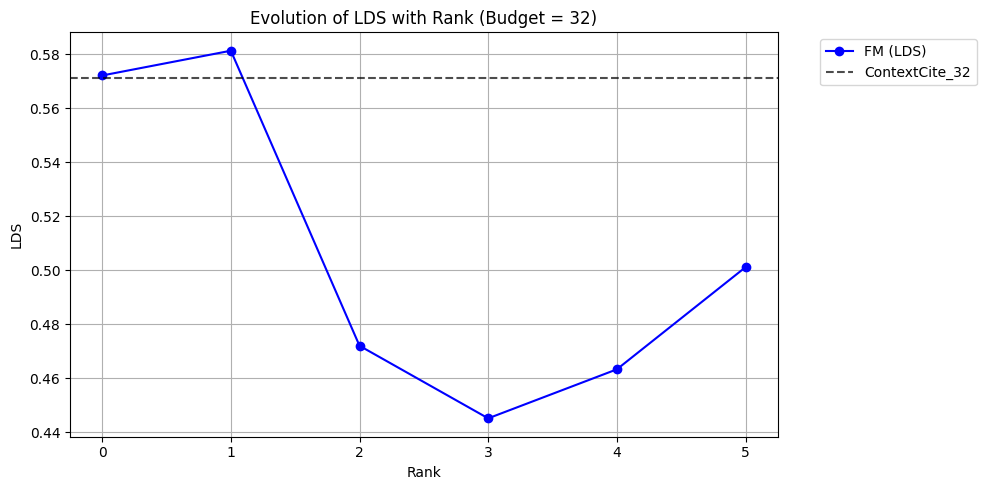

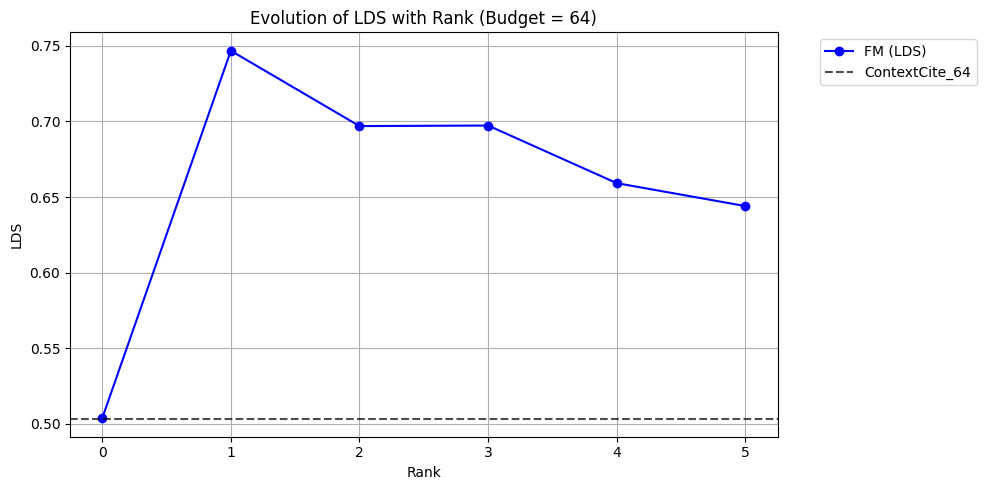

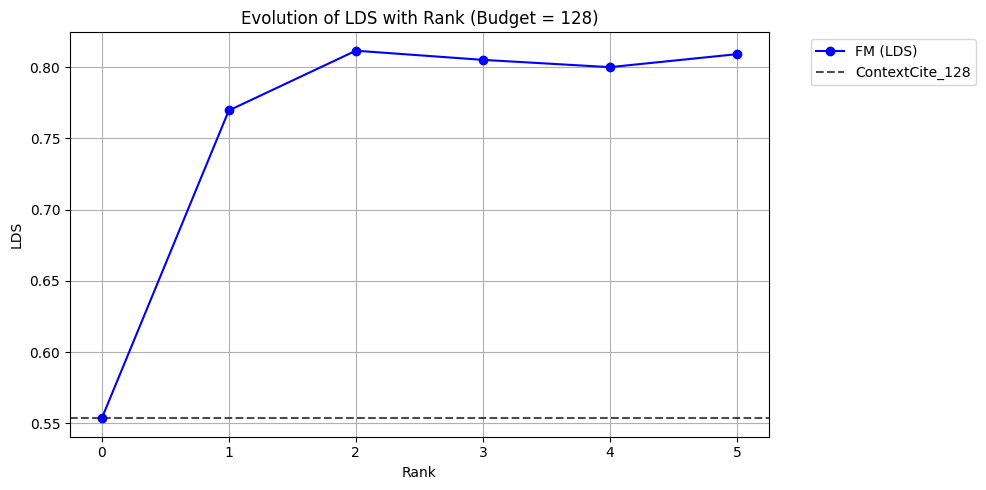

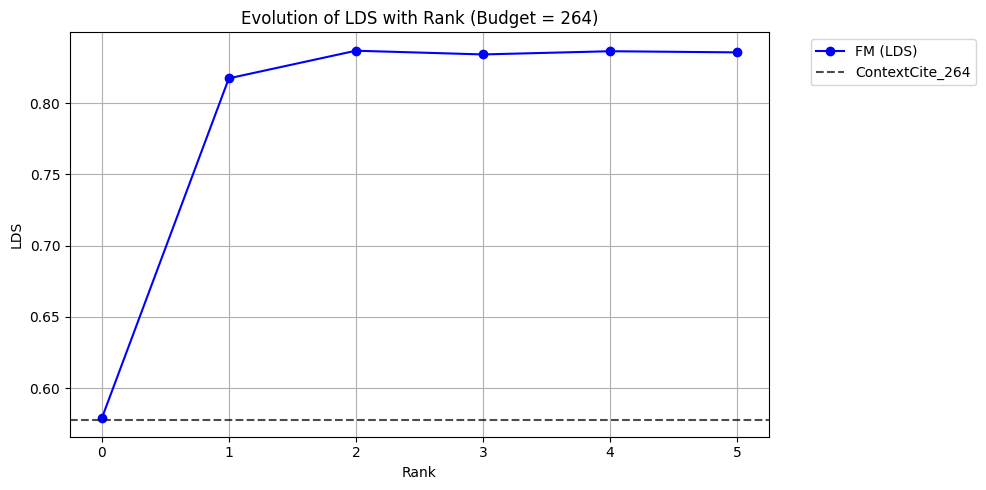

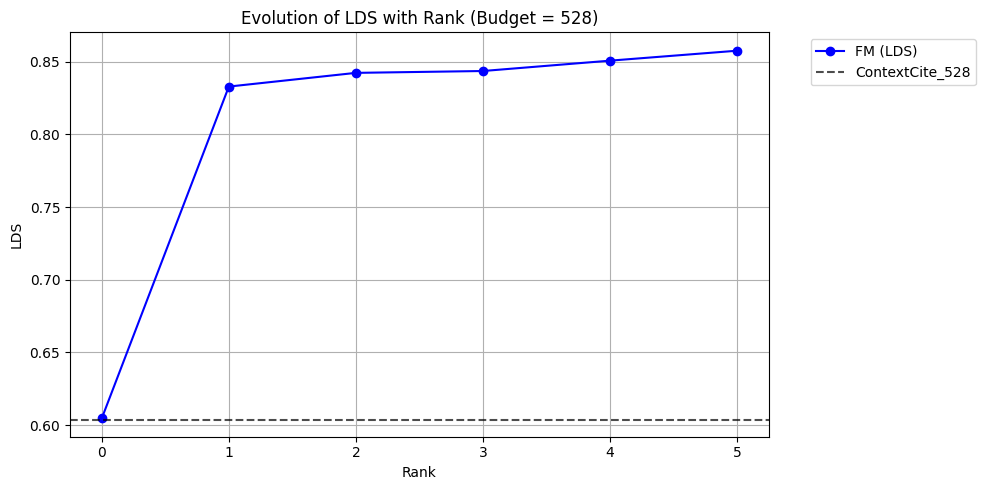

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Parse FM methods (rank + budget)
def parse_fm(method):
    parts = method.split("_")
    if parts[0] == "FM" and "WeightsLU" in parts[1]:
        rank = int(parts[2])
        budget = int(parts[-1])
        return rank, budget
    return None, None

df_reset['rank'], df_reset['budget'] = zip(*df_reset['method'].apply(parse_fm))

# Separate FM and non-FM methods
df_fm = df_reset[df_reset['rank'].notnull()]
df_nonfm = df_reset[df_reset['rank'].isnull()]

# Keep only ContextCite baselines
df_contextcite = df_nonfm[df_nonfm['method'].str.startswith("ContextCite")]

# Function to plot R² for a given budget
def plot_r2_for_budget(budget):
    plt.figure(figsize=(10, 5))

    # Subset FM methods for this budget
    subset_fm = df_fm[df_fm['budget'] == budget].sort_values(by='rank')

    # Plot FM evolution (R² vs rank)
    plt.plot(subset_fm['rank'], subset_fm['LDS'], marker='o', color="blue", label="FM (LDS)")

    # Plot only ContextCite baselines for this budget
    for _, row in df_contextcite.iterrows():
        if row['method'].endswith(f"_{budget}"):
            plt.axhline(y=row['LDS'], linestyle='--', color="black", alpha=0.7, label=row['method'])

    plt.xlabel("Rank")
    plt.ylabel("LDS")
    plt.title(f"Evolution of LDS with Rank (Budget = {budget})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot for budget = 528
plot_r2_for_budget(32)
plot_r2_for_budget(64)
plot_r2_for_budget(128)
plot_r2_for_budget(264)
plot_r2_for_budget(528)

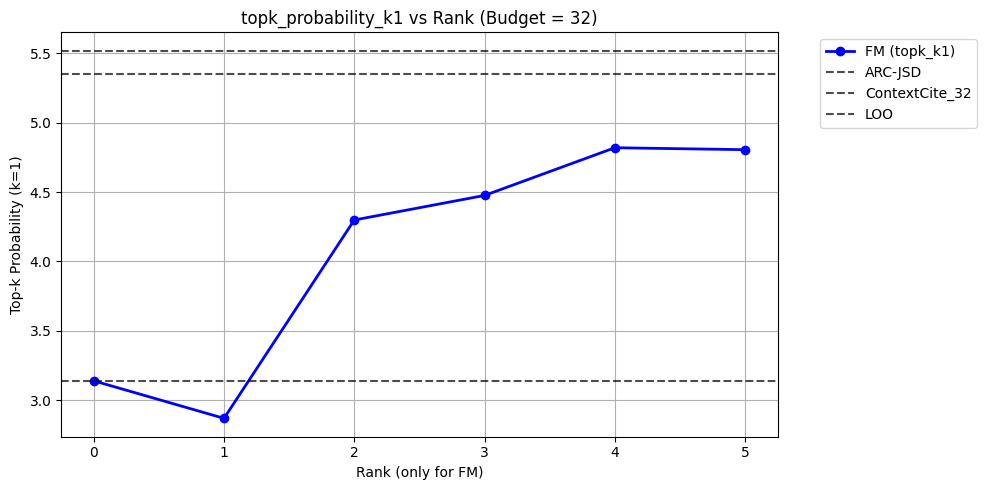

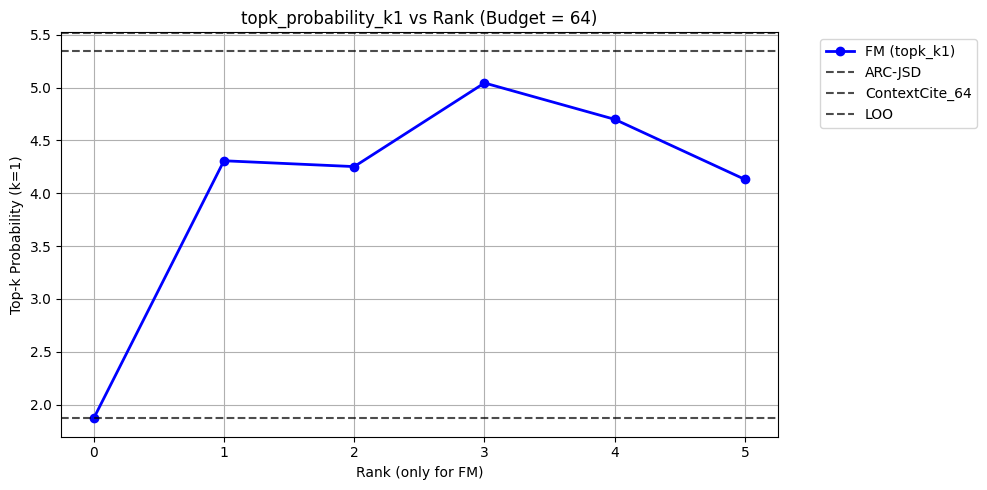

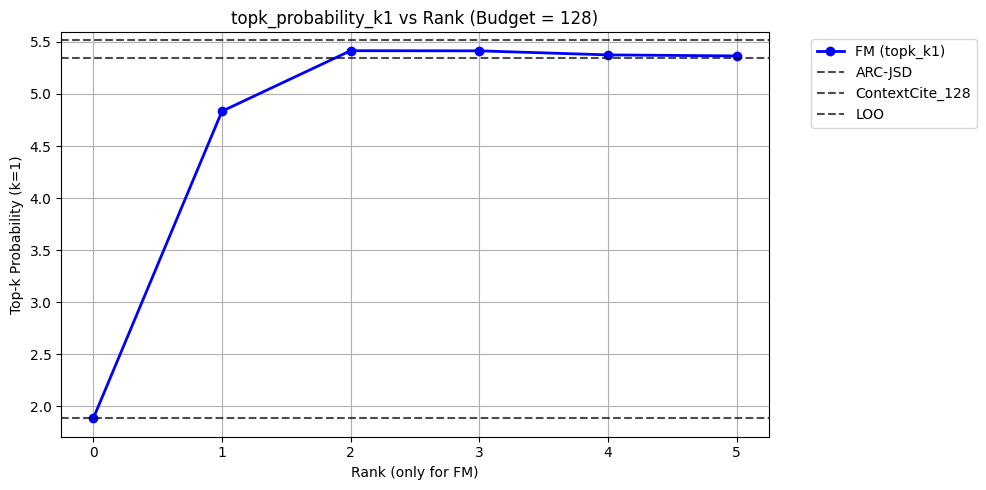

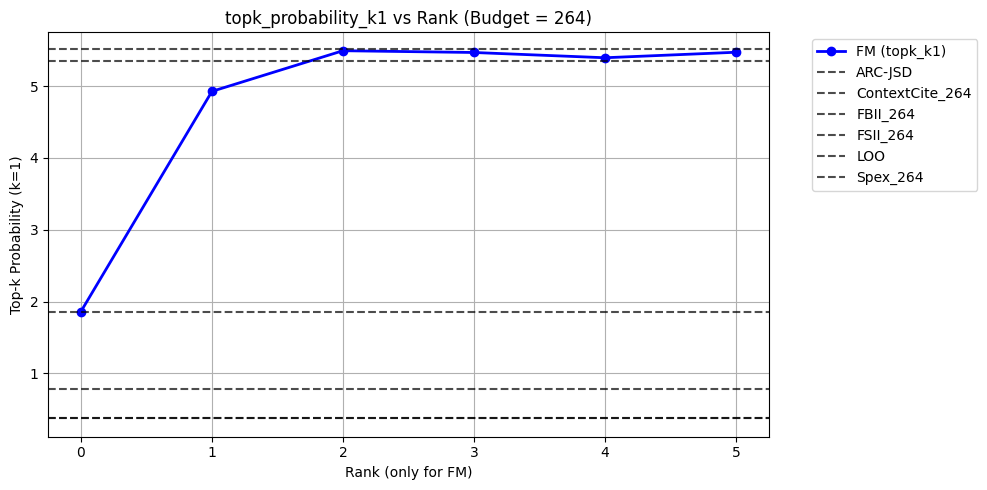

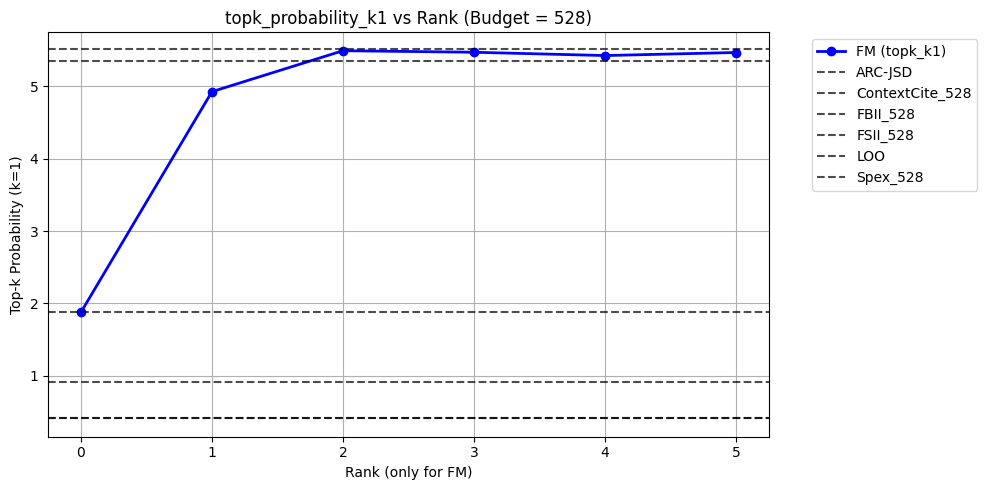

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Parse FM methods (rank + budget)
def parse_fm(method):
    parts = method.split("_")
    if parts[0] == "FM" and "WeightsLU" in parts[1]:
        rank = int(parts[2])
        budget = int(parts[-1])
        return rank, budget
    return None, None

df_reset['rank'], df_reset['budget'] = zip(*df_reset['method'].apply(parse_fm))

# Separate FM and non-FM methods
df_fm = df_reset[df_reset['rank'].notnull()]
df_nonfm = df_reset[df_reset['rank'].isnull()]

# Function to plot topk_probability_k1 for a given budget
def plot_topk_for_budget(budget):
    plt.figure(figsize=(10, 5))

    # Subset FM methods for this budget
    subset_fm = df_fm[df_fm['budget'] == budget].sort_values(by='rank')

    # Plot FM evolution (vs rank)
    plt.plot(subset_fm['rank'], subset_fm['topk_probability_k1'],
             marker='o', color="blue", linewidth=2, label="FM (topk_k1)")

    # Plot all other methods as black dashed lines
    for _, row in df_nonfm.iterrows():
        if row['method'].endswith(f"_{budget}") or row['method'] in ["LOO", "ARC-JSD"]:
            plt.axhline(y=row['topk_probability_k1'],
                        linestyle='--', color="black", alpha=0.7, label=row['method'])

    plt.xlabel("Rank (only for FM)")
    plt.ylabel("Top-k Probability (k=1)")
    plt.title(f"topk_probability_k1 vs Rank (Budget = {budget})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot for budget = 528
plot_topk_for_budget(32)
plot_topk_for_budget(64)
plot_topk_for_budget(128)
plot_topk_for_budget(264)
plot_topk_for_budget(528)


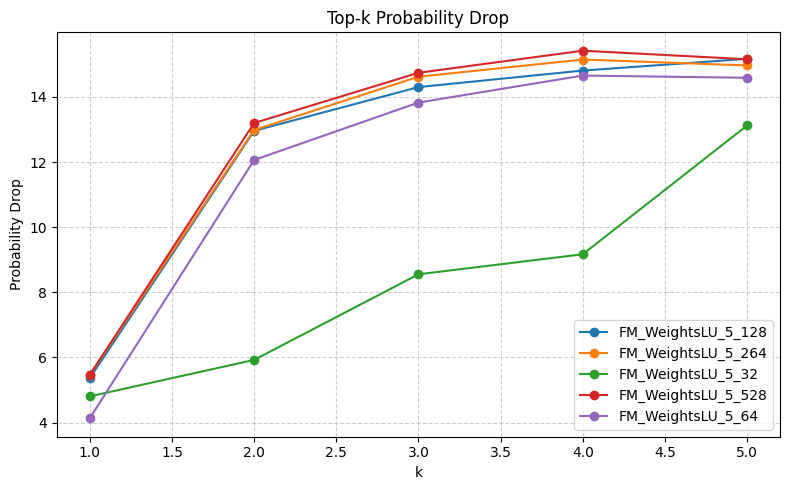

In [11]:
plt.figure(figsize=(8, 5))
for method in df_res.index:
    if "FM_WeightsLU_5" in method:
        plt.plot(
            [1, 2, 3,4,5],
            df_res.loc[method, ['topk_probability_k1', 'topk_probability_k2', 'topk_probability_k3', 'topk_probability_k4', 'topk_probability_k5']],
            marker='o',
            label=method
        )

plt.xlabel('k')
plt.ylabel('Probability Drop')
plt.title('Top-k Probability Drop')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Second stage

In [12]:
import numpy as np

def evaluate_methods(extras, k, m, interaction_type="max"):

    methods = extras[1].keys()
    scores = {m: 0 for m in methods}
    n_experiments = len(extras)

    for exp in extras:
        for method in methods:
            if "Flu"in method:
                # Flu is a matrix
                value = exp[method][k][m]
                all_values = exp[method].flatten()
            else:
                # Dictionaries with tuple keys
                d = exp[method]
                value = None
                for key, v in d.items():
                    ones = [i for i, bit in enumerate(key) if bit == 1]
                    if set(ones) == {k, m}:
                        value = v
                        break
                if value is None:
                    continue  # skip if (k,m) not found
                all_values = list(d.values())

            if interaction_type == "max":
                if value == max(all_values):
                    scores[method] += 1
            elif interaction_type == "min":
                if value == min(all_values):
                    scores[method] += 1

    # Convert to fraction of experiments
    results = {method: scores[method] / n_experiments for method in methods}
    return results

In [15]:
# Recovery rate
rr={}
for i, j in enumerate(np.array(list(evaluate_methods(extras, k=0, m=1, interaction_type="max").values()))+np.array(list(evaluate_methods(extras, k=0, m=5, interaction_type="max").values()))+np.array(list(evaluate_methods(extras, k=5, m=1, interaction_type="min").values()))):
    rr.update({list(extras[1].keys())[i]:j})

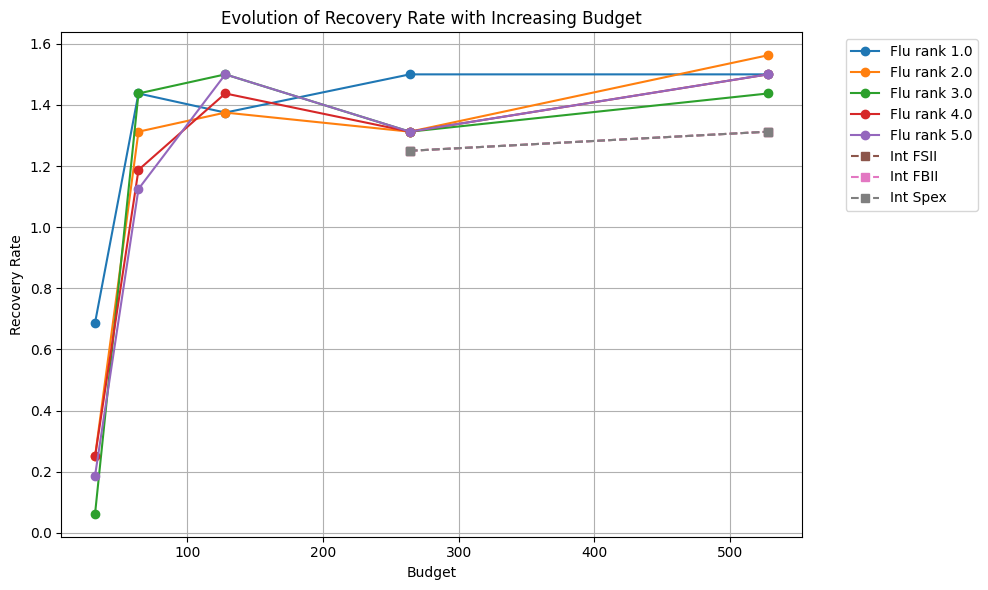

In [21]:
rows = []
for k, v in rr.items():
    parts = k.split("_")
    if parts[0] == "Flu" and parts[1]!='0':
        _, rank, budget = parts
        rows.append({"method": "Flu", "rank": int(rank), "budget": int(budget), "recovery": v})
    elif parts[0] == "Int":
        _, name, budget = parts
        rows.append({"method": name, "rank": None, "budget": int(budget), "recovery": v})

df = pd.DataFrame(rows)

# Plot
plt.figure(figsize=(10, 6))

# Plot Flu (different ranks as lines)
for rank in sorted(df[df["method"]=="Flu"]["rank"].unique()):
    sub = df[(df["method"]=="Flu") & (df["rank"]==rank)].sort_values("budget")
    plt.plot(sub["budget"], sub["recovery"], marker="o", label=f"Flu rank {rank}")

# Plot Int methods (evolve with budget, start at 264)
for m in df[df["method"].isin(["FSII","FBII","Spex"])]['method'].unique():
    sub = df[df["method"]==m].sort_values("budget")
    plt.plot(sub["budget"], sub["recovery"], marker="s", linestyle="--", label=f"Int {m}")

plt.xlabel("Budget")
plt.ylabel("Recovery Rate")
plt.title("Evolution of Recovery Rate with Increasing Budget")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()